In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
sales_data = pd.read_excel('Online_Retail.xlsx')

In [3]:
total = sales_data.isnull().sum().sort_values(ascending = False)
percent = (sales_data.isnull().sum()/sales_data.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
CustomerID,135080,24.926694
Description,1454,0.268311
Country,0,0.000000
UnitPrice,0,0.000000
InvoiceDate,0,0.000000


In [4]:
#remove canceled orders
dataset=sales_data[sales_data['Quantity']>0]

In [5]:
total = dataset.isnull().sum().sort_values(ascending = False)
percent = (dataset.isnull().sum()/dataset.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
CustomerID,133361,25.101593
Description,592,0.111428
Country,0,0.000000
UnitPrice,0,0.000000
InvoiceDate,0,0.000000


In [6]:
dataset.dropna(subset=['CustomerID'],how='all',inplace=True)

In [7]:
#exploring the unique values of each attribute
print("Number of transactions: ", dataset['InvoiceNo'].nunique())
print("Number of products bought: ",dataset['StockCode'].nunique())
print("Number of customers:", dataset['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(dataset['CustomerID'].isnull().sum() * 100 / len(dataset),2),"%" )

Number of transactions:  18536
Number of products bought:  3665
Number of customers: 4339
Percentage of customers NA:  0.0 %


In [8]:
dataset['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [9]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [10]:
dataset['date'] = dataset['InvoiceDate'].dt.date

In [11]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [12]:
#group by customers and check last date of purshace
recency_data = dataset.groupby(by='CustomerID', as_index=False)['date'].max()
recency_data.columns = ['CustomerID','LastPurshaceDate']
recency_data.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [13]:
recency_data['Recency'] = recency_data['LastPurshaceDate'].apply(lambda x: (now - x).days)
print(recency_data.head())
recency_data.drop('LastPurshaceDate',axis=1,inplace=True)
recency_data.head()

   CustomerID LastPurshaceDate  Recency
0     12346.0       2011-01-18      325
1     12347.0       2011-12-07        2
2     12348.0       2011-09-25       75
3     12349.0       2011-11-21       18
4     12350.0       2011-02-02      310


,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [14]:
data_copy=dataset.copy()
# drop duplicates
data_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_data = data_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_data.columns = ['CustomerID','Frequency']
frequency_data.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [15]:
dataset['TotalCost'] = dataset['Quantity'] * dataset['UnitPrice']

In [16]:
monetary_data = dataset.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_data.columns = ['CustomerID','Monetary']
monetary_data.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [17]:
rfm_data = recency_data.merge(frequency_data.merge(monetary_data,on='CustomerID'),on='CustomerID')
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,310,1,334.40


In [18]:
#use CustomerID as index
rfm_data.set_index('CustomerID',inplace=True)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40


In [19]:
rfm_data.shape

(4339, 3)

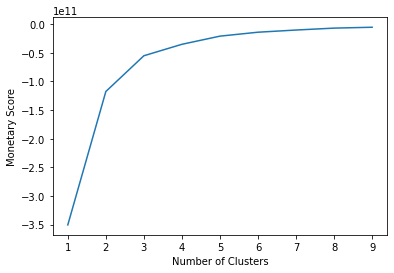

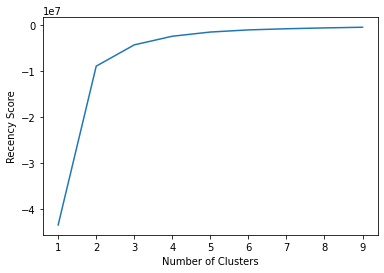

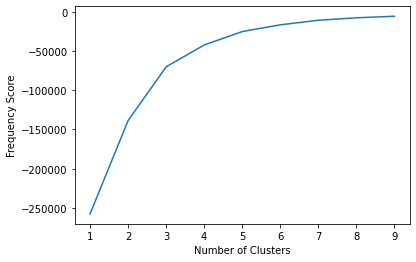

In [20]:
km = rfm_data.copy()
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = km[['Monetary']]
score_Monetary = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score_Monetary)
plt.xlabel('Number of Clusters')
plt.ylabel('Monetary Score')
plt.show()

Y_axis = km[['Recency']]
score_Recency = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score_Recency)
plt.xlabel('Number of Clusters')
plt.ylabel('Recency Score')
plt.show()

Y_axis = km[['Frequency']]
score_Frequency = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score_Frequency)
plt.xlabel('Number of Clusters')
plt.ylabel('Frequency Score')
plt.show()

In [21]:
kmeans = KMeans(n_clusters = 4, init ='random',max_iter=20000,tol=0.00001)
kmeans.fit(km)
km['cluster_label'] = kmeans.fit_predict(km)
centers = kmeans.cluster_centers_
labels = kmeans.predict(km)
km.cluster_label.unique()

ValueError: Incorrect number of features. Got 4 features, expected 3

In [ ]:
km.plot.scatter(x = 'Monetary', y = 'Recency', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.8)

In [ ]:
km.plot.scatter(x = 'Frequency', y = 'Recency', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.8)

In [ ]:
km.plot.scatter(x = 'Frequency', y = 'Monetary', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.8)

In [ ]:
kmeans

In [ ]:
f, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(15,6))
ax1.set_title('K Means')
ax1.scatter(km['Recency'],km['Monetary'],c=kmeans.labels_,cmap='brg')

In [ ]:
f, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(15,6))
ax1.set_title('K Means')
ax1.scatter(km['Frequency'],km['Monetary'],c=kmeans.labels_,cmap='brg')

In [ ]:
f, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(15,6))
ax1.set_title('K Means')
ax1.scatter(km['Frequency'],km['Recency'],c=kmeans.labels_,cmap='brg')